In [6]:
import math
import collections

import pandas as pd

from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import *

import params
from utils.sequence_data import data_to_sequences_and_labels
from utils.metrics import print_report_for_binary_classfier
from utils.preprocessing import probs_to_binary_classes
from utils.hyperparams import hyperparams_search
from utils.plot import plot_train_validation_metric

In [7]:
dataset = pd.read_csv("../datasets/data_for_models/dataset_1996-01-01_2019-08-22.csv",
                           header=0, parse_dates=[0], index_col=0)

input_shape = (params.LOOKBACK//params.STEP, dataset.shape[-1] )

In [8]:
#params for generating sequences 
train_max_idx = math.ceil(len(dataset)*params.TRAIN_RATIO)
val_max_idx = math.ceil(len(dataset)*(params.TRAIN_RATIO+params.VAL_RATIO))
label_index = len(dataset.columns) -1


# prepare data
train_X, train_Y = data_to_sequences_and_labels(dataset.to_numpy(), params.LOOKBACK, 
                                                params.STEP, 
                                                0, train_max_idx, 
                                                params.DELAY,
                                                label_index) 
val_X, val_Y = data_to_sequences_and_labels(dataset.to_numpy(), params.LOOKBACK, 
                                                params.STEP, 
                                                train_max_idx+1, val_max_idx, 
                                                params.DELAY,
                                                label_index)
test_X, test_Y = data_to_sequences_and_labels(dataset.to_numpy(), params.LOOKBACK, 
                                                params.STEP, 
                                                val_max_idx+1, None, 
                                                params.DELAY,
                                                label_index)

In [9]:
def lstm_model(hidden_unit, n_layer, l2_weight, input_shape):
    model = Sequential()
    is_return_sequences = True if n_layer>=2 else False
    
    # first layer
    model.add(LSTM(hidden_unit, 
                   input_shape=input_shape,
                   kernel_regularizer=regularizers.l2(l2_weight),
                   recurrent_regularizer=regularizers.l2(l2_weight),
                   return_sequences=is_return_sequences))
    
    # intermediate layers
    if n_layer >= 3:
        for _ in range(n_layer-2):
            model.add(LSTM(hidden_unit,
                           kernel_regularizer=regularizers.l2(l2_weight),
                           recurrent_regularizer=regularizers.l2(l2_weight),
                           return_sequences=is_return_sequences))

    
    # last layer
    if n_layer >= 2:
        model.add(LSTM(hidden_unit,
                       recurrent_regularizer=regularizers.l2(l2_weight),
                       kernel_regularizer=regularizers.l2(l2_weight)))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
best_params = hyperparams_search(model_func=fc_model, 
                                 input_shape=input_shape,
                                 train_X=train_X, train_Y=train_Y, 
                                 val_X=val_X, val_Y=val_Y,
                                 num_epoch=2000,
                                 hidden_units=[32,64], 
                                 n_layers=[2,3], 
                                 l2_weights=[0,0.0001,0.001, 0.01],
                                 is_verbose=0)
print("\nbest params = {0}".format(best_params))

Train on 4033 samples, validate on 853 samples
Epoch 1/1
4033/4033 [==============================] - 4s 984us/step - loss: 0.5290 - acc: 0.7600 - val_loss: 0.3775 - val_acc: 0.8957
Train on 4033 samples, validate on 853 samples
Epoch 1/1
4033/4033 [==============================] - 4s 1ms/step - loss: 0.5228 - acc: 0.7610 - val_loss: 0.2169 - val_acc: 0.9683
Train on 4033 samples, validate on 853 samples
Epoch 1/1
4033/4033 [==============================] - 5s 1ms/step - loss: 0.5552 - acc: 0.7563 - val_loss: 0.1573 - val_acc: 0.9871
Train on 4033 samples, validate on 853 samples
Epoch 1/1
4033/4033 [==============================] - 6s 2ms/step - loss: 0.5404 - acc: 0.7602 - val_loss: 0.1597 - val_acc: 0.9871
Train on 4033 samples, validate on 853 samples
Epoch 1/1
4033/4033 [==============================] - 4s 1ms/step - loss: 0.5487 - acc: 0.7587 - val_loss: 0.3368 - val_acc: 0.8628
Train on 4033 samples, validate on 853 samples
Epoch 1/1
4033/4033 [==============================

In [12]:
#hyperparameters
num_epoch = best_params['epochs'] 
n_layer= best_params['n_layer'] 
hidden_unit=best_params['hidden_unti']  
l2_weight=best_params['l2_weight']

model = lstm_model(hidden_unit, n_layer, l2_weight, input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

# #fit the model
history = model.fit(train_X, train_Y,
                    validation_data=(val_X, val_Y),
                    epochs=num_epoch,
                    verbose=1)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 15, 64)            25088     
_________________________________________________________________
lstm_42 (LSTM)               (None, 15, 64)            33024     
_________________________________________________________________
lstm_43 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 91,201
Trainable params: 91,201
Non-trainable params: 0
_________________________________________________________________
None
Train on 4033 samples, validate on 853 samples
Epoch 1/1
4033/4033 [==============================] - 10s 2ms/step - loss: 0.5620 - acc: 0.7570 - val_loss: 0.2087 - val_acc: 0.9871


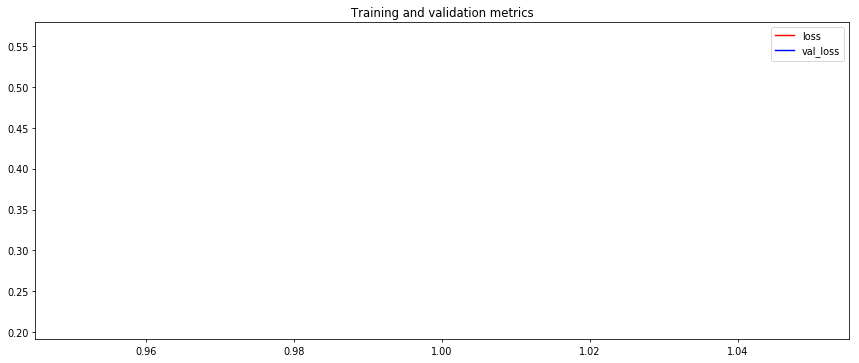

In [13]:
plot_train_validation_metric(history, 'loss', 'val_loss')

## We have 2984 positive and 984 negtive cases. 

In [18]:
#Make predictions for train set   
print(collections.Counter(train_Y))
print_report_for_binary_classfier(train_Y, probs_to_binary_classes(model.predict(train_X)))

Counter({0.0: 3049, 1.0: 984})
F1 score: 0.190061
precision score: 0.668712
recall score: 0.110772
accuracy score: 0.769650
matthews_corrcoef: 0.202954

Confusion matrix:
[[2995   54]
 [ 875  109]]


In [19]:
#Make predictions from dev set
print(collections.Counter(val_Y))
print_report_for_binary_classfier(val_Y, probs_to_binary_classes(model.predict(val_X)))

Counter({0.0: 842, 1.0: 11})
F1 score: 0.000000
precision score: 0.000000
recall score: 0.000000
accuracy score: 0.987104
matthews_corrcoef: 0.000000

Confusion matrix:
[[842   0]
 [ 11   0]]


In [20]:
#Make predictions for test set
print(collections.Counter(test_Y))
print_report_for_binary_classfier(test_Y, probs_to_binary_classes(model.predict(test_X)))

Counter({0.0: 811, 1.0: 30})
F1 score: 0.000000
precision score: 0.000000
recall score: 0.000000
accuracy score: 0.964328
matthews_corrcoef: 0.000000

Confusion matrix:
[[811   0]
 [ 30   0]]


# Save the best model

In [21]:
from keras.models import load_model

model.save(params.BEST_LSTM_MODEL_PATH)  # creates a HDF5 file 'my_model.h5'